In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

%matplotlib inline

In [6]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


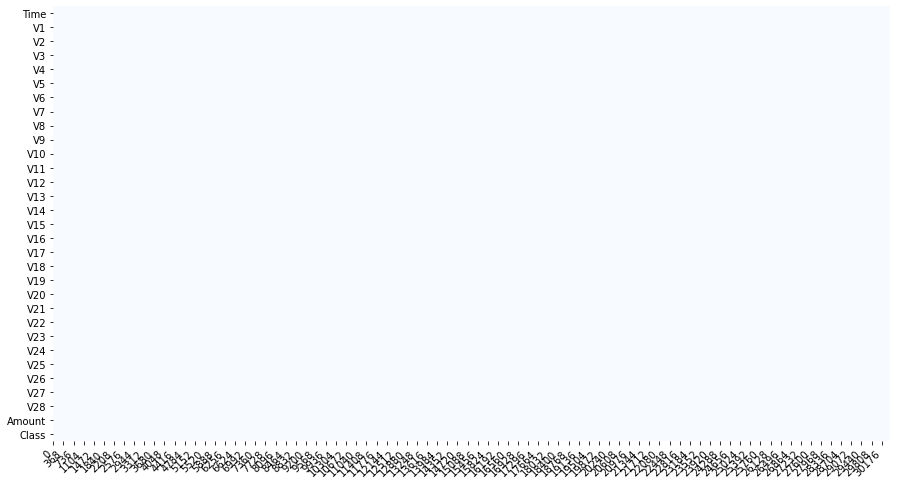

In [7]:
plot_missing_value(df)

In [9]:
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24393, 30), (6099, 30), (24393,), (6099,))

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.9995080555897183 0.9983191899315377 0.999344154779472


### Imbalance Data

In [14]:
df.Class.value_counts()

0    30000
1      492
Name: Class, dtype: int64

In [15]:
# Baseline
30000/30492

0.9838646202282566

#### Akurasi tidak dipakai untuk imbalance dataser
By default, kita tidak boleh pakai akurasi sebagai metrik ketika datanya imbalance. Pakailah F1-score.

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.9847715736040609 0.9461901651981198 0.9795918367346939


In [18]:
from jcopml.plot import plot_confusion_matrix

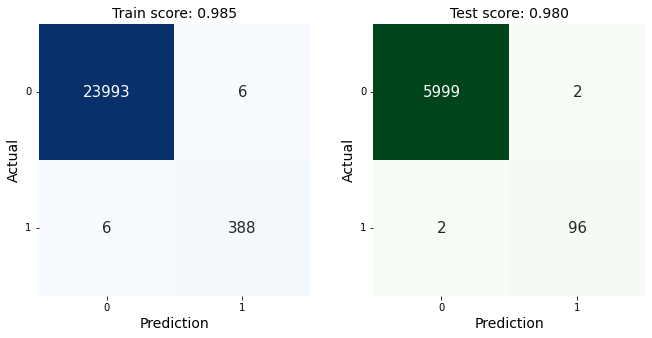

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

### Improve with Class Weight

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])
parameter = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C' : np.logspace(-3, 3, 7),
    'algo__class_weight' : [{0: x, 1: 1-x} for x in [0.05, 0.1, 0.25]]
}
model = GridSearchCV(pipeline, parameter, cv=3, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 147 candidates, totalling 441 fits


C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 100.0, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__gamma': 0.001}
0.9683944374209861 0.9459107232676489 0.9746192893401016


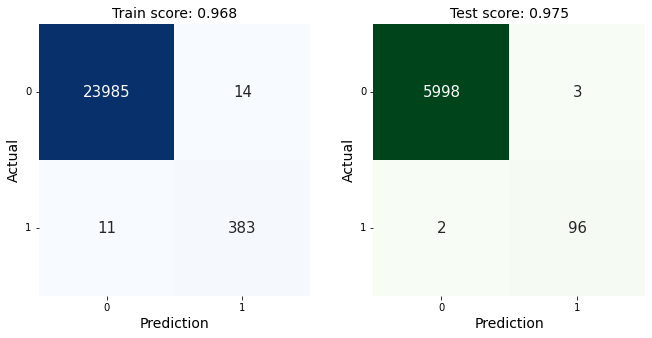

In [22]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)